# BCI Competition IV: CNN vs GCN

In [9]:
import numpy as np
import mne
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Load BCI Competition IV Dataset 2a

In [10]:
data_list = []
labels_list = []

for subject in range(1, 10):
    train_file = f'BCI_2a/A0{subject}T.gdf'
    raw = mne.io.read_raw_gdf(train_file, preload=True, verbose=False)
    events, event_id = mne.events_from_annotations(raw, verbose=False)
    
    mi_event_ids = {k: v for k, v in event_id.items() if k in ['769', '770', '771', '772']}
    
    if len(mi_event_ids) > 0:
        epochs = mne.Epochs(raw, events, event_id=mi_event_ids,
                           tmin=0, tmax=4, baseline=None, preload=True, verbose=False)
        
        data = epochs.get_data()
        labels = epochs.events[:, -1]
        label_mapping = {v: i for i, (k, v) in enumerate(sorted(mi_event_ids.items(), key=lambda x: x[1]))}
        labels = np.array([label_mapping[l] for l in labels])
        
        data_list.append(data)
        labels_list.append(labels)
        print(f'Subject {subject}: {data.shape[0]} epochs')

X = np.concatenate(data_list, axis=0)
y = np.concatenate(labels_list, axis=0)

print(f'\nTotal: {X.shape} - 4 classes')
num_channels = X.shape[1]
num_timepoints = X.shape[2]

Subject 1: 288 epochs
Subject 2: 288 epochs
Subject 3: 288 epochs
Subject 4: 288 epochs
Subject 5: 288 epochs
Subject 6: 288 epochs
Subject 7: 288 epochs
Subject 8: 288 epochs
Subject 9: 288 epochs

Total: (2592, 25, 1001) - 4 classes


## Prepare Data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, num_timepoints)).reshape(-1, num_channels, num_timepoints)
X_test = scaler.transform(X_test.reshape(-1, num_timepoints)).reshape(-1, num_channels, num_timepoints)

y_train_cat = keras.utils.to_categorical(y_train, 4)
y_test_cat = keras.utils.to_categorical(y_test, 4)

print(f'Train: {X_train.shape}, Test: {X_test.shape}')

Train: (2073, 25, 1001), Test: (519, 25, 1001)


## Compute Graph Structure

In [12]:
def compute_adjacency_from_pearson(data):
    n_epochs, n_channels, n_timepoints = data.shape
    data_reshaped = data.transpose(1, 0, 2).reshape(n_channels, -1)
    correlation_matrix = np.corrcoef(data_reshaped)
    adjacency = np.abs(correlation_matrix)
    np.fill_diagonal(adjacency, 1.0)
    return adjacency.astype(np.float32)

def compute_laplacian(adjacency):
    D = np.sum(adjacency, axis=1)
    D_sqrt_inv = np.diag(1.0 / np.sqrt(D + 1e-6))
    L = np.eye(len(adjacency)) - D_sqrt_inv @ adjacency @ D_sqrt_inv
    lambda_max = np.linalg.eigvalsh(L)[-1]
    L_rescaled = (2.0 / lambda_max) * L - np.eye(len(L))
    return L_rescaled.astype(np.float32)

adjacency = compute_adjacency_from_pearson(X_train)
L_rescaled = compute_laplacian(adjacency)
print(f'Adjacency: {adjacency.shape}, Laplacian: {L_rescaled.shape}')

Adjacency: (25, 25), Laplacian: (25, 25)


## Chebyshev Graph Convolution

In [13]:
class ChebyshevGraphConv(layers.Layer):
    def __init__(self, num_filters, K=3, **kwargs):
        super().__init__(**kwargs)
        self.num_filters = num_filters
        self.K = K

    def build(self, input_shape):
        self.theta = [self.add_weight(shape=(input_shape[0][-1], self.num_filters),
                                     initializer='glorot_uniform', name=f'theta_{k}')
                     for k in range(self.K)]
        super().build(input_shape)

    def call(self, inputs):
        x, L_rescaled = inputs
        Tx_0 = x
        Tx_1 = tf.matmul(L_rescaled, x)
        out = tf.matmul(Tx_0, self.theta[0])
        if self.K > 1:
            out += tf.matmul(Tx_1, self.theta[1])
        for k in range(2, self.K):
            Tx_2 = 2 * tf.matmul(L_rescaled, Tx_1) - Tx_0
            out += tf.matmul(Tx_2, self.theta[k])
            Tx_0, Tx_1 = Tx_1, Tx_2
        return out

## CNN Model

In [14]:
def create_cnn(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Permute((2, 1))(inputs)
    
    x = layers.Conv1D(64, 50, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv1D(128, 25, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv1D(256, 10, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_cnn((num_channels, num_timepoints), 4)
print(f'CNN: {cnn_model.count_params():,} parameters')

CNN: 648,132 parameters


## GCN Model

In [15]:
def create_gcn(input_shape, num_classes, num_channels, L_rescaled):
    inputs = layers.Input(shape=input_shape)
    x = layers.Permute((2, 1))(inputs)
    
    x = layers.Conv1D(64, 50, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv1D(128, 25, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    cnn_features = x
    
    channel_input = layers.Input(shape=(num_channels, num_timepoints))
    channel_avg = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_input)
    
    L_tensor = tf.constant(L_rescaled, dtype=tf.float32)
    graph_features = ChebyshevGraphConv(64, K=2)([channel_avg, L_tensor])
    graph_features = layers.Flatten()(graph_features)
    
    combined = layers.Concatenate()([cnn_features, graph_features])
    x = layers.Dense(128, activation='relu')(combined)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model([inputs, channel_input], outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

gcn_model = create_gcn((num_channels, num_timepoints), 4, num_channels, L_rescaled)
print(f'GCN: {gcn_model.count_params():,} parameters')

GCN: 507,716 parameters


## Metrics Callback

In [16]:
class MetricsCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.history_dict = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
        self.best_val_acc = 0
        self.decreasing_count = 0

    def on_epoch_end(self, epoch, logs=None):
        for key in self.history_dict.keys():
            if key in logs:
                self.history_dict[key].append(logs[key])
        
        if logs.get('val_accuracy', 0) < self.best_val_acc:
            self.decreasing_count += 1
        else:
            self.best_val_acc = logs.get('val_accuracy', 0)
            self.decreasing_count = 0
        
        if self.decreasing_count >= 3 and epoch >= 19:
            print(f"\nStopping: Accuracy has decreased for {self.decreasing_count} consecutive epochs")
            self.model.stop_training = True

In [17]:
cnn_metrics_callback = MetricsCallback()

cnn_history = cnn_model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[
        cnn_metrics_callback,
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy'),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, monitor='val_loss', verbose=1)
    ],
    verbose=1
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.2799 - loss: 1.4624 - val_accuracy: 0.2217 - val_loss: 3.0902 - learning_rate: 0.0010
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.3703 - loss: 1.3102 - val_accuracy: 0.2867 - val_loss: 1.4670 - learning_rate: 0.0010
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.4698 - loss: 1.1963 - val_accuracy: 0.3470 - val_loss: 1.4527 - learning_rate: 0.0010
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.5302 - loss: 1.1009 - val_accuracy: 0.4530 - val_loss: 1.3022 - learning_rate: 0.0010
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.5887 - loss: 1.0036 - val_accuracy: 0.4940 - val_loss: 1.3334 - learning_rate: 0.0010
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6116 - loss: 0.9628 - val_accuracy: 0.5470 - val_loss: 1.0776 - learning_rate: 0.0010
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.6279 - loss: 0.9056 - val_accuracy: 

## Train CNN

In [18]:
gcn_metrics_callback = MetricsCallback()

gcn_history = gcn_model.fit(
    [X_train, X_train], y_train_cat,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[
        gcn_metrics_callback,
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy'),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, monitor='val_loss', verbose=1)
    ],
    verbose=1
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.2871 - loss: 1.3793 - val_accuracy: 0.3325 - val_loss: 1.6277 - learning_rate: 0.0010
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.3908 - loss: 1.2931 - val_accuracy: 0.2651 - val_loss: 1.4124 - learning_rate: 0.0010
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5090 - loss: 1.1707 - val_accuracy: 0.4675 - val_loss: 1.2200 - learning_rate: 0.0010
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 889ms/step - accuracy: 0.5519 - loss: 1.0756 - val_accuracy: 0.4747 - val_loss: 1.1761 - learning_rate: 0.0010
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5953 - loss: 0.9876 - val_accuracy: 0.5349 - val_loss: 1.1133 - learning_rate: 0.0010
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6267 - loss: 0.9095 - val_accuracy: 0.5301 - val_loss: 1.1792 - learning_rate: 0.0010
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6496 - loss: 0.8731 - val_accurac

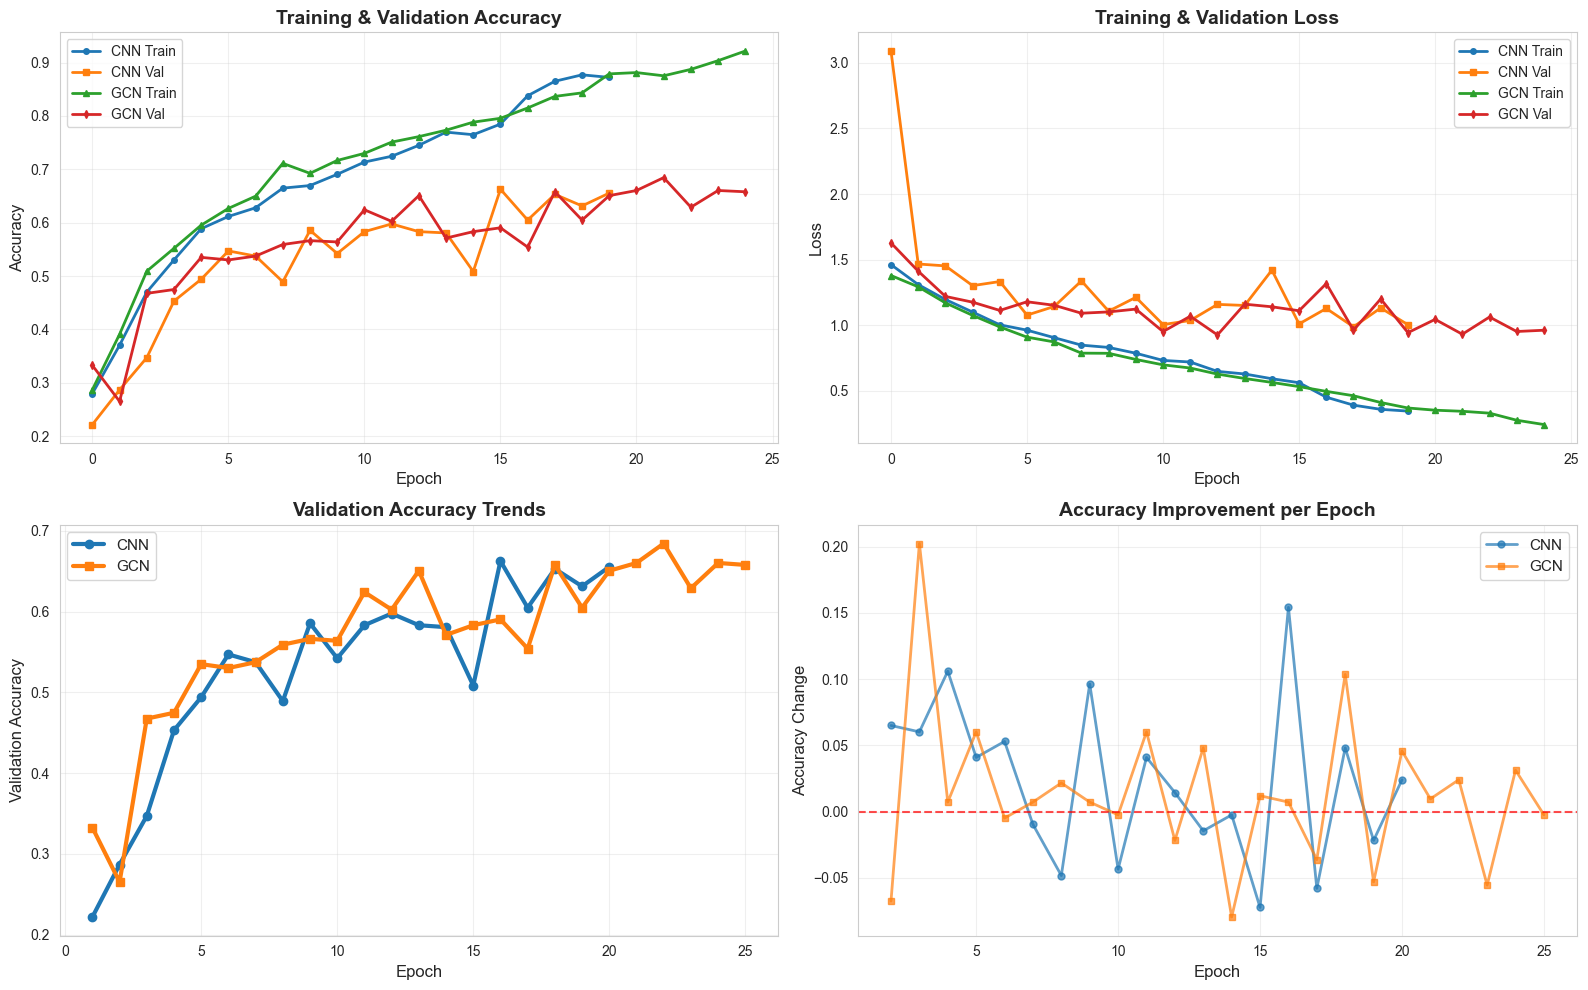

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0, 0].plot(cnn_metrics_callback.history_dict['accuracy'], label='CNN Train', linewidth=2, marker='o', markersize=4)
axes[0, 0].plot(cnn_metrics_callback.history_dict['val_accuracy'], label='CNN Val', linewidth=2, marker='s', markersize=4)
axes[0, 0].plot(gcn_metrics_callback.history_dict['accuracy'], label='GCN Train', linewidth=2, marker='^', markersize=4)
axes[0, 0].plot(gcn_metrics_callback.history_dict['val_accuracy'], label='GCN Val', linewidth=2, marker='d', markersize=4)
axes[0, 0].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].legend(loc='best', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(cnn_metrics_callback.history_dict['loss'], label='CNN Train', linewidth=2, marker='o', markersize=4)
axes[0, 1].plot(cnn_metrics_callback.history_dict['val_loss'], label='CNN Val', linewidth=2, marker='s', markersize=4)
axes[0, 1].plot(gcn_metrics_callback.history_dict['loss'], label='GCN Train', linewidth=2, marker='^', markersize=4)
axes[0, 1].plot(gcn_metrics_callback.history_dict['val_loss'], label='GCN Val', linewidth=2, marker='d', markersize=4)
axes[0, 1].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Loss', fontsize=12)
axes[0, 1].legend(loc='best', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

epochs_cnn = range(1, len(cnn_metrics_callback.history_dict['accuracy']) + 1)
epochs_gcn = range(1, len(gcn_metrics_callback.history_dict['accuracy']) + 1)
axes[1, 0].plot(epochs_cnn, cnn_metrics_callback.history_dict['val_accuracy'], label='CNN', linewidth=3, marker='o', markersize=6)
axes[1, 0].plot(epochs_gcn, gcn_metrics_callback.history_dict['val_accuracy'], label='GCN', linewidth=3, marker='s', markersize=6)
axes[1, 0].set_title('Validation Accuracy Trends', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Validation Accuracy', fontsize=12)
axes[1, 0].legend(loc='best', fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

improvement_cnn = np.diff(cnn_metrics_callback.history_dict['val_accuracy'])
improvement_gcn = np.diff(gcn_metrics_callback.history_dict['val_accuracy'])
axes[1, 1].plot(range(2, len(epochs_cnn)+1), improvement_cnn, label='CNN', linewidth=2, marker='o', markersize=5, alpha=0.7)
axes[1, 1].plot(range(2, len(epochs_gcn)+1), improvement_gcn, label='GCN', linewidth=2, marker='s', markersize=5, alpha=0.7)
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
axes[1, 1].set_title('Accuracy Improvement per Epoch', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Accuracy Change', fontsize=12)
axes[1, 1].legend(loc='best', fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Visualizations

FINAL RESULTS
CNN Accuracy: 64.55%
GCN Accuracy: 68.40%
WINNER: GCN (+3.85%)


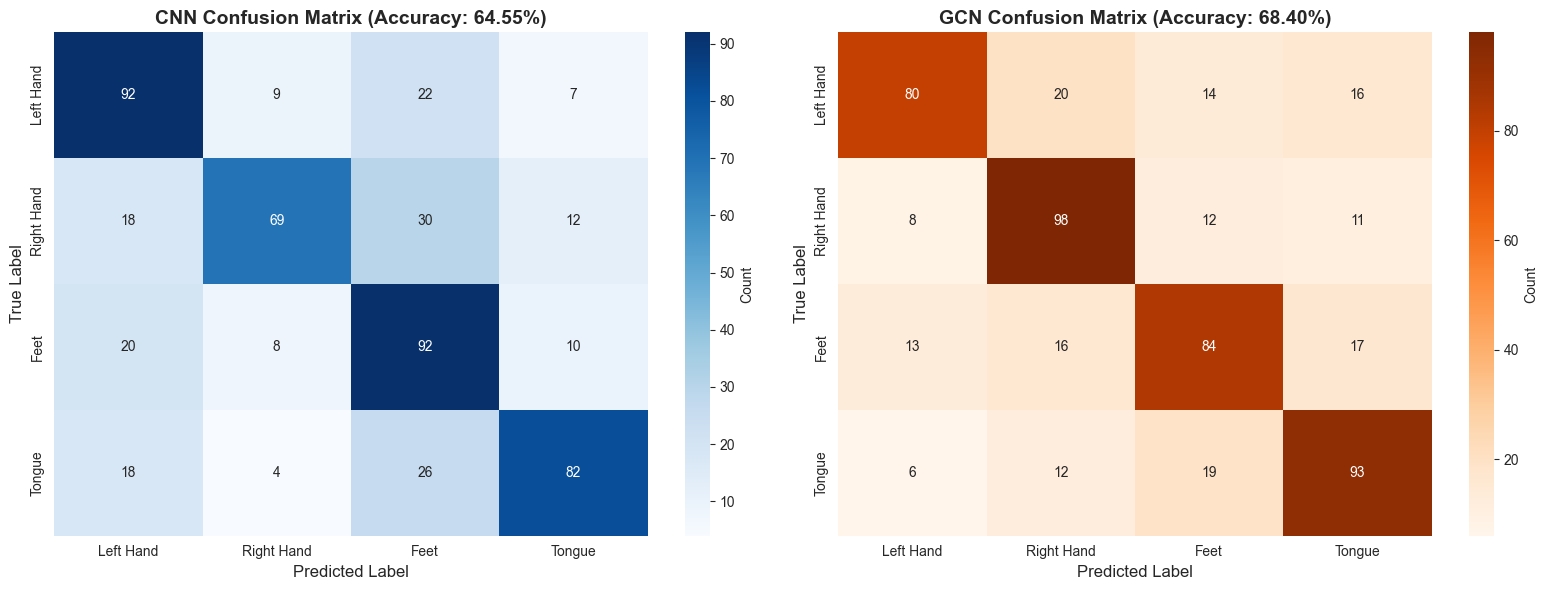


CNN Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.62      0.71      0.66       130
  Right Hand       0.77      0.53      0.63       129
        Feet       0.54      0.71      0.61       130
      Tongue       0.74      0.63      0.68       130

    accuracy                           0.65       519
   macro avg       0.67      0.65      0.65       519
weighted avg       0.67      0.65      0.65       519


GCN Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.75      0.62      0.68       130
  Right Hand       0.67      0.76      0.71       129
        Feet       0.65      0.65      0.65       130
      Tongue       0.68      0.72      0.70       130

    accuracy                           0.68       519
   macro avg       0.69      0.68      0.68       519
weighted avg       0.69      0.68      0.68       519



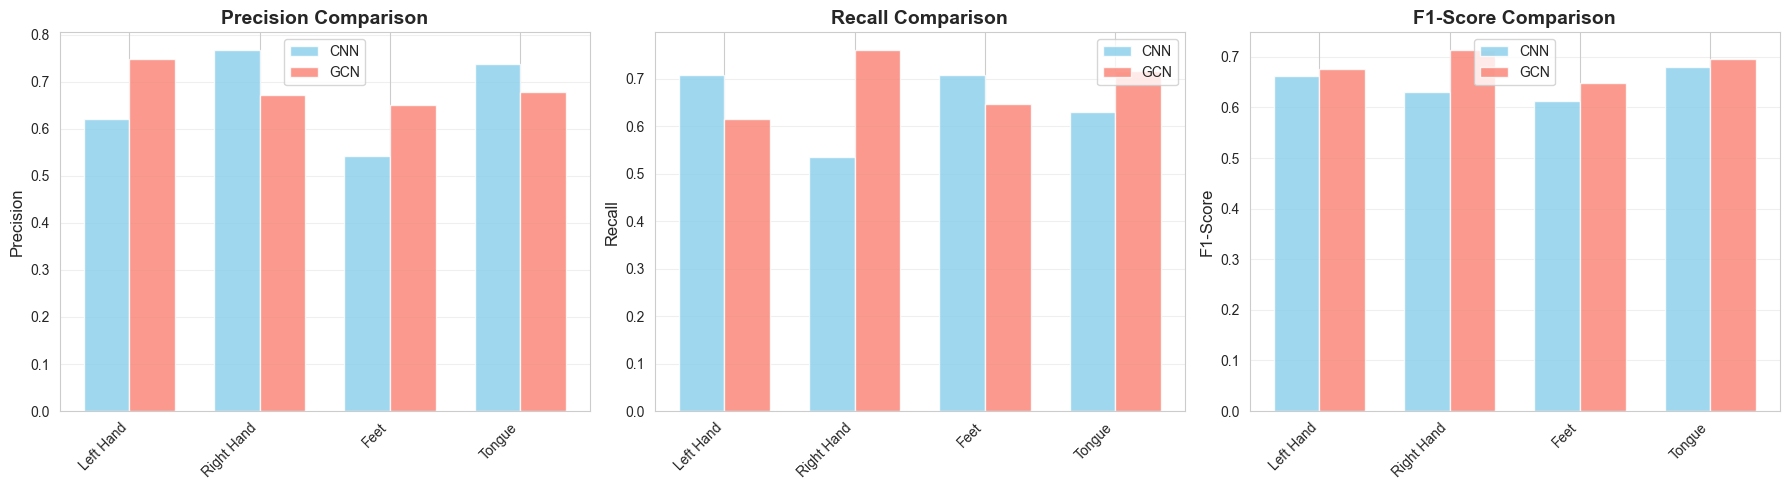


MODEL COMPARISON SUMMARY
       Metric     CNN     GCN
Test Accuracy  64.55%  68.40%
    Test Loss  1.0255  0.9003
   Parameters 648,132 507,716
Avg Precision  0.6671  0.6872
   Avg Recall  0.6453  0.6842
 Avg F1-Score  0.6465  0.6833


In [20]:
cnn_loss, cnn_acc = cnn_model.evaluate(X_test, y_test_cat, verbose=0)
gcn_loss, gcn_acc = gcn_model.evaluate([X_test, X_test], y_test_cat, verbose=0)

cnn_preds = cnn_model.predict(X_test, verbose=0)
gcn_preds = gcn_model.predict([X_test, X_test], verbose=0)

cnn_pred_classes = np.argmax(cnn_preds, axis=1)
gcn_pred_classes = np.argmax(gcn_preds, axis=1)
y_test_classes = np.argmax(y_test_cat, axis=1)

class_names = ['Left Hand', 'Right Hand', 'Feet', 'Tongue']

print('='*70)
print('FINAL RESULTS')
print('='*70)
print(f'CNN Accuracy: {cnn_acc*100:.2f}%')
print(f'GCN Accuracy: {gcn_acc*100:.2f}%')
print('='*70)

if gcn_acc > cnn_acc:
    print(f'WINNER: GCN (+{(gcn_acc-cnn_acc)*100:.2f}%)')
else:
    print(f'WINNER: CNN (+{(cnn_acc-gcn_acc)*100:.2f}%)')

cnn_cm = confusion_matrix(y_test_classes, cnn_pred_classes)
gcn_cm = confusion_matrix(y_test_classes, gcn_pred_classes)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, 
            yticklabels=class_names, ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title(f'CNN Confusion Matrix (Accuracy: {cnn_acc*100:.2f}%)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

sns.heatmap(gcn_cm, annot=True, fmt='d', cmap='Oranges', xticklabels=class_names, 
            yticklabels=class_names, ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title(f'GCN Confusion Matrix (Accuracy: {gcn_acc*100:.2f}%)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

print("\nCNN Classification Report:")
print(classification_report(y_test_classes, cnn_pred_classes, target_names=class_names))
print("\nGCN Classification Report:")
print(classification_report(y_test_classes, gcn_pred_classes, target_names=class_names))

cnn_precision, cnn_recall, cnn_f1, _ = precision_recall_fscore_support(y_test_classes, cnn_pred_classes, average=None)
gcn_precision, gcn_recall, gcn_f1, _ = precision_recall_fscore_support(y_test_classes, gcn_pred_classes, average=None)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
x = np.arange(len(class_names))
width = 0.35

axes[0].bar(x - width/2, cnn_precision, width, label='CNN', color='skyblue', alpha=0.8)
axes[0].bar(x + width/2, gcn_precision, width, label='GCN', color='salmon', alpha=0.8)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_title('Precision Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(class_names, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(x - width/2, cnn_recall, width, label='CNN', color='skyblue', alpha=0.8)
axes[1].bar(x + width/2, gcn_recall, width, label='GCN', color='salmon', alpha=0.8)
axes[1].set_ylabel('Recall', fontsize=12)
axes[1].set_title('Recall Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(class_names, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

axes[2].bar(x - width/2, cnn_f1, width, label='CNN', color='skyblue', alpha=0.8)
axes[2].bar(x + width/2, gcn_f1, width, label='GCN', color='salmon', alpha=0.8)
axes[2].set_ylabel('F1-Score', fontsize=12)
axes[2].set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
axes[2].set_xticks(x)
axes[2].set_xticklabels(class_names, rotation=45, ha='right')
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

summary_data = {
    'Metric': ['Test Accuracy', 'Test Loss', 'Parameters', 'Avg Precision', 'Avg Recall', 'Avg F1-Score'],
    'CNN': [
        f'{cnn_acc*100:.2f}%',
        f'{cnn_loss:.4f}',
        f'{cnn_model.count_params():,}',
        f'{np.mean(cnn_precision):.4f}',
        f'{np.mean(cnn_recall):.4f}',
        f'{np.mean(cnn_f1):.4f}'
    ],
    'GCN': [
        f'{gcn_acc*100:.2f}%',
        f'{gcn_loss:.4f}',
        f'{gcn_model.count_params():,}',
        f'{np.mean(gcn_precision):.4f}',
        f'{np.mean(gcn_recall):.4f}',
        f'{np.mean(gcn_f1):.4f}'
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print(summary_df.to_string(index=False))
print("="*70)